In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

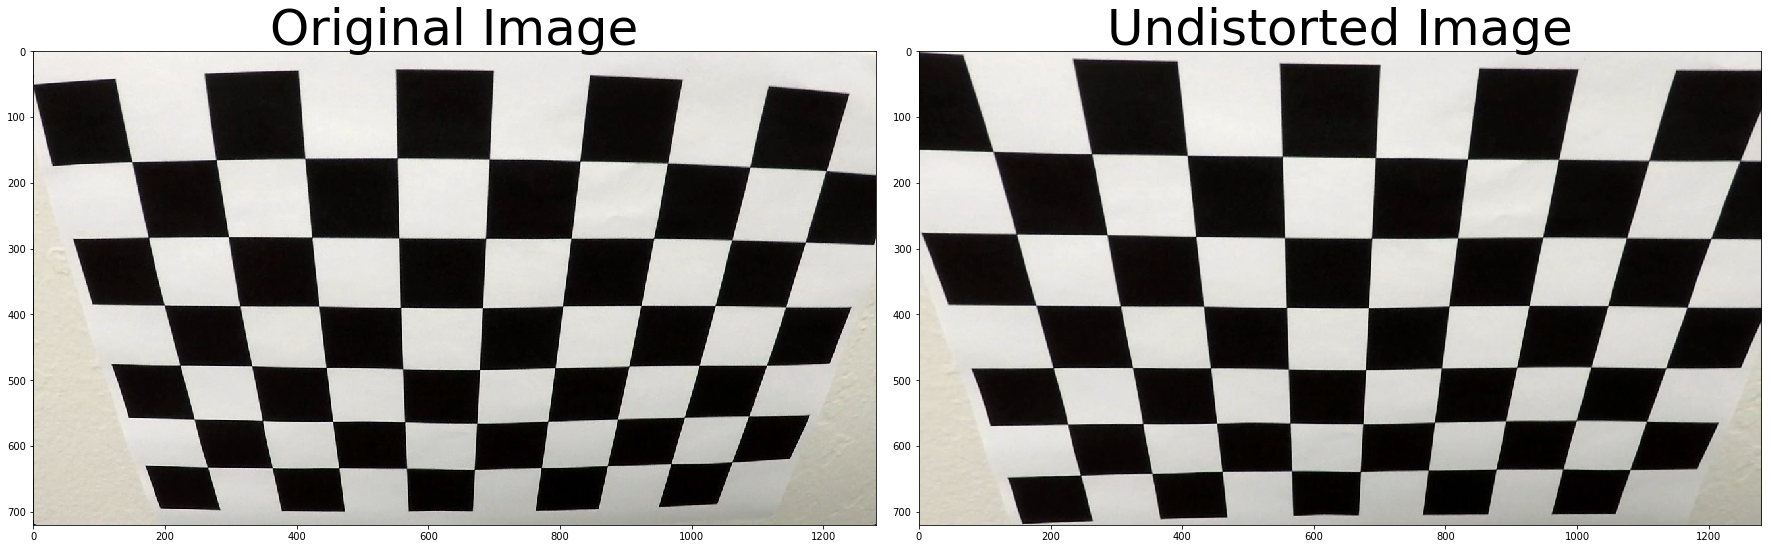

In [2]:
def caliberation():
    objpoints=[]
    imgpoints=[]

    nx=9
    ny=6

    objp=np.zeros((nx*ny,3),np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    images = glob.glob('camera_cal/calibration*.jpg')

    for fname in images:
        img=mpimg.imread(fname)
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners=cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            #img=cv2.drawChessboardCorners(img,(6,8), corners, ret)
            #plt.imshow(img)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    
    return mtx,dist

mtx, dist = caliberation()
img = mpimg.imread('camera_cal/calibration2.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
#undistorted=caliberation(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
def get_perspective(img):
    src = np.float32([[(585,460),(203,720),(1127,720),(695,460)]])
    dst=np.float32([[(320,0),(320,720),(960,720),(960,0)]])
    image_shape=img.shape
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    img_size = (image_shape[1], image_shape[0])
    view = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)
    return M_inv, view

In [4]:
def abs_sobel_thresh(img,orient='x',thresh_min=0,thresh_max=255):
    if orient=='x':
        sobel=cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel=cv2.Sobel(img, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

In [5]:
def color_mask(img):
    #Thresholds
    yellow_lower_filter = np.array([0, 100, 100])
    yellow_upper_filter = np.array([80, 255, 255])

    white_lower_filter = np.array([200, 200, 200])
    white_upper_filter = np.array([255, 255, 255])

    #yellow masking
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow_mask = cv2.inRange(hsv, yellow_lower_filter, yellow_upper_filter)
    yellow_mask = cv2.bitwise_and(img, img, mask=yellow_mask)

    #white masking
    rgb = img
    white_mask = cv2.inRange(rgb, white_lower_filter, white_upper_filter)
    white_mask = cv2.bitwise_and(img, img, mask=white_mask)

    #combined masks
    combined_mask = cv2.addWeighted(white_mask, 1., yellow_mask, 1., 0.)

    #convert to binary image
    gray_mask = cv2.cvtColor(combined_mask, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray_mask)
    binary[(gray_mask > 0)] = 1
    return binary
    #return yellow_mask, white_mask, binary


    

In [25]:
def measure_radius_of_curvature(x_values,num_rows):
    img_size = (img.shape[1], img.shape[0])
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

In [34]:
def pipeline(img):
    
    img_size = (img.shape[1], img.shape[0])
    img_shape=img.shape
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    M_inv, view=get_perspective(undistorted)
    hls = cv2.cvtColor(view,cv2.COLOR_RGB2HLS)
    h=hls[:,:,0]
    l=hls[:,:,1]
    s=hls[:,:,2]
    sobelx_light_mask = abs_sobel_thresh(l, orient='x', thresh_min=50, thresh_max=225)
    sobelx_saturation_mask = abs_sobel_thresh(s, orient='x', thresh_min=50, thresh_max=225)
    combined_sobel = cv2.bitwise_or(sobelx_light_mask, sobelx_saturation_mask)
    color_binary=color_mask(view)
    final_mask = cv2.bitwise_or(combined_sobel,color_binary)
    binary_warped = np.copy(final_mask)
    num_rows=binary_warped.shape[0]
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img_shape[1], img_shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    curverad_left = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    curverad_right = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    average_curve_rad = (curverad_left + curverad_right)/2


    # compute the offset from the center
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    
    
    
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int(average_curve_rad)), (120,140),
             cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color=(255,255,255), thickness = 3)
    # Print distance from center on video
    if lane_center > 640:
        cv2.putText(result, 'Vehicle is {:.2f}(m) left of the center'.format(center_offset_mtrs), (100,80),
                 cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color=(255,255,255), thickness = 3)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}(m) right of the center'.format(center_offset_mtrs), (100,80),
                 cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color=(255,255,255), thickness = 3)
        
    #Left.count += 1
    return result
    
    
    
    return result

    
    

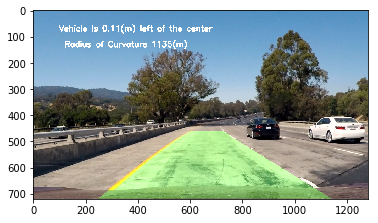

In [35]:
img = mpimg.imread('test_images/test1.jpg')
result=pipeline(img)
plt.imshow(result)

In [36]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'first_draft.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video first_draft.mp4
[MoviePy] Writing video first_draft.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:29<00:00,  3.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: first_draft.mp4 

Wall time: 6min 32s
